# Implement ARIMA on XxX degrees area

/Users/jurrienboogert/opt/anaconda3/envs/arima/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jurrienboogert/opt/anaconda3/envs/arima/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jurrienboogert/opt/anaconda3/envs/arima/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jurrienboogert/opt/anaconda3/envs/arima/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary start

accuracy: 0.5971362229102167
precision: 0.6976902173913043
recall: 0.6327788046826864
specificity: 0.5369406867845994
Mean Absolute Error: 1.4783827823919635


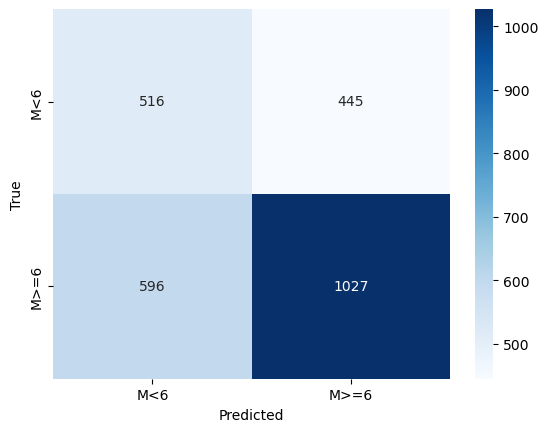

                               SARIMAX Results                                
Dep. Variable:              Magnitude   No. Observations:                   24
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -6.886
Date:                Thu, 23 Mar 2023   AIC                             17.772
Time:                        12:09:55   BIC                             20.043
Sample:                    07-17-2022   HQIC                            18.343
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6651      0.280     -2.371      0.018      -1.215      -0.115
sigma2         0.1039      0.038      2.752      0.006       0.030       0.178
Ljung-Box (L1) (Q):                   0.29   Jarque-

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Choose frequency, binsize, longitude, latitude
freq = 'W'
binsize = 5
longitude_W = 140 # minimum is 134
longitude_E = 145 # maximum is 174
latitude_S = 35 # minimum is 10
latitude_N = 40 # minimum is 60

# Define cut-off magnitude
mag = 4.5

# load earthquake data for the defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
data = data['Magnitude'].resample(freq).max()  # resample by day and get the maximum magnitude of the day
data = data.fillna(0)

# Choose lookback-window with train_size (multiple of freq)
train_size = 12 * 2
total_splits = len(data)-train_size
# test_size is number of timewindows to predict into the future (is 1)
test_size = 1

# Generate split
cv = TimeSeriesSplit(n_splits=total_splits, max_train_size=train_size ,test_size=test_size)

mae_total = 0
TP = 0
FP = 0
TN = 0
FN = 0

y_true = []
y_pred = []

# Train the model and safe predictions
for train_index, test_index in cv.split(data):
    #print("TRAIN:", train_index, "TEST:", test_index)

    # fit an ARIMA model
    model = ARIMA(data[train_index], order=(1, 1, 0))  # (p, d, q) order
    model_fit = model.fit()

    # forecast next week's magnitudes
    forecast = model_fit.forecast(steps=test_size)
    # print('true:', data[test_index][0], 'prediction:', round(forecast[0],1))

    # evaluate model performance
    mae = mean_absolute_error(data[test_index], forecast)
    mae_total += mae
    #print('inermediate MSE:', mse)

    if data[test_index][0] >= mag:
        y_true.append(1)
        if forecast[0] >= mag:
            y_pred.append(1)
            TP += 1
        if forecast[0] < mag:
            FN += 1
            y_pred.append(0)
    if data[test_index][0] < mag:
        y_true.append(0)
        if forecast[0] >= mag:
            y_pred.append(1)
            FP += 1
        if forecast[0] < mag:
            y_pred.append(0)
            TN += 1

# Evaluate the performance
acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP+FN)
specificity = TN / (TN+FP)

print('accuracy:', acc)
print('precision:', precision)
print('recall:', recall)
print('specificity:', specificity)
print('Mean Absolute Error:', mae_total/total_splits)

cm = confusion_matrix(y_true, y_pred)
class_names = ['M<6','M>=6']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print model summary
print(model_fit.summary())


## visualise ACF to define MA

<BarContainer object of 35 artists>

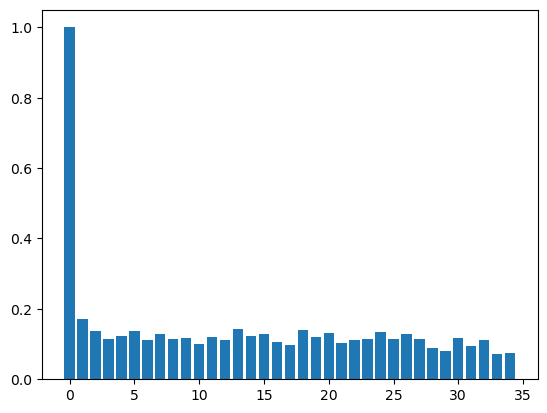

In [2]:
acf_val = acf(data)
plt.bar(range(0,len(acf_val)),acf_val)

## visualize PACF to define AR

<BarContainer object of 35 artists>

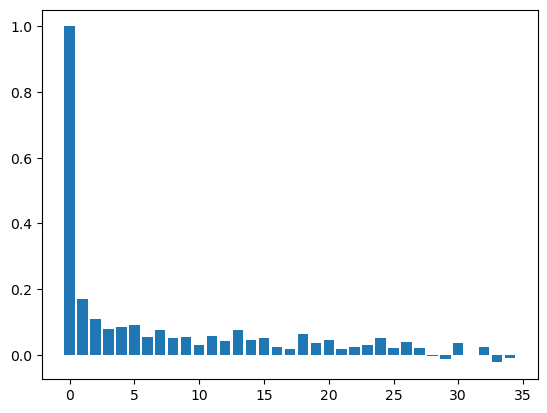

In [3]:
pacf_val = pacf(data)
plt.bar(range(0,len(pacf_val)),pacf_val)

# LSTM univariate/multivariate

### Create 2d array

In [39]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
# By changing the binsize and longitude/latitude a multivariate timeseries can be created
freq = 'W'
binsize = 5
longitude_W = 140 # minimum is 134
longitude_E = 145 # maximum is 174
latitude_S = 35 # minimum is 10
latitude_N = 40 # minimum is 60

# load earthquake data for defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into XxX degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E+1, binsize))
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N+1, binsize))

# Group the data by longitude bin, latitude bin, and freq, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level='Time')])['Magnitude'].max()

# Convert the resulting data to a DataFrame, filling missing values with 0
grouped_df = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor with shape (1, time, rows, cols, channels)
time = len(grouped_df.columns)
rows = len(grouped_df.index.levels[0])
cols = len(grouped_df.index.levels[1])
dataset = np.zeros((1, time, rows, cols, 1))

for t in range(time):
    dataset[0, t, :, :, 0] = grouped_df.iloc[:, t].values.reshape(rows, cols)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
dataset = np.transpose(dataset, axes=(0, 1, 3, 2, 4))
dataset = np.flip(dataset, axis=2)

dataset = dataset.reshape((dataset.shape[1], -1))
dataset = dataset[:, dataset.any(axis=0)]

# Print the shape of the resulting tensor
print(dataset.shape)

(2608, 1)


### Create train and test sets

In [55]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

# define magnitude cutoff
mag = 4.5
mag_select = (dataset >= mag)

# scale data
# scaler = StandardScaler()
# dataset = scaler.fit_transform(dataset)

# split data in train en test set
train, test = train_test_split(dataset, test_size=.3, shuffle=False, random_state=43)
mag_train, mag_test = train_test_split(mag_select, test_size=.3, shuffle=False, random_state=43)

# define generator
n_features = dataset.shape[1]

# define lookback-timewindow
n_input = 52
steps_epoch = 32
train_generator = TimeseriesGenerator(train, mag_train.astype(int), length=n_input, batch_size=(len(train) - n_input) // steps_epoch, shuffle=False)
test_generator = TimeseriesGenerator(test, mag_test.astype(int), length=n_input, batch_size=(len(test) - n_input) // steps_epoch, shuffle=False)

## Construct LSTM (univariate/multivariate)

In [56]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Flatten, Input, TimeDistributed, Dropout, RepeatVector, BatchNormalization
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import keras
from keras.callbacks import EarlyStopping
from keras import backend as K

keras.backend.clear_session()

# define model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(256, activation='relu',
               return_sequences=True,
               input_shape=(n_input, n_features)))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu',
               return_sequences=False))
model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(n_features, activation='sigmoid'))

model.build(input_shape=(None, n_input, n_features))
print(model.summary())

opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 52, 1)            4         
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 52, 256)           264192    
                                                                 
 batch_normalization_1 (Batc  (None, 52, 256)          1024      
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                        

### fit model

In [57]:
# early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)
# fit model
history = model.fit(train_generator, validation_data=test_generator, steps_per_epoch=steps_epoch, epochs=1000, verbose=1, callbacks=[callback])

Epoch 1/1000
32/32 [==============================] - 7s 176ms/step - loss: 0.7058 - precision: 0.5360 - recall: 0.7574 - accuracy: 0.5215 - val_loss: 0.7044 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.1464
Epoch 2/1000
32/32 [==============================] - 6s 176ms/step - loss: 0.6906 - precision: 0.5535 - recall: 0.6980 - accuracy: 0.5332 - val_loss: 0.6964 - val_precision: 0.6101 - val_recall: 0.1554 - val_accuracy: 0.1943
Epoch 3/1000
32/32 [==============================] - 6s 191ms/step - loss: 0.6820 - precision: 0.5711 - recall: 0.7313 - accuracy: 0.5605 - val_loss: 0.6847 - val_precision: 0.8484 - val_recall: 0.9599 - val_accuracy: 0.8194
Epoch 4/1000
32/32 [==============================] - 6s 201ms/step - loss: 0.6796 - precision: 0.5713 - recall: 0.7557 - accuracy: 0.5669 - val_loss: 0.6747 - val_precision: 0.8536 - val_recall: 1.0000 - val_accuracy: 0.8536
Epoch 5/1000
32/32 [==============================] - 7s 210ms/step - loss: 0.6751 - pre

### predict

In [58]:
y_pred = model.predict(test_generator)

# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(test)

34/34 [==============================] - 1s 33ms/step


### evaluation metrics

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('F1 score: %f' % f1)

class_names = ['M<4.5', 'M>=4.5']

print(classification_report(test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5, target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(test >= mag, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("zeroR:", round(zeroR,4))

Accuracy: 0.818057
Precision: 0.851689
Recall: 0.947712
F1 score: 0.897138
              precision    recall  f1-score   support

       M<4.5       0.36      0.15      0.21       119
      M>=4.5       0.85      0.95      0.90       612

    accuracy                           0.82       731
   macro avg       0.61      0.55      0.56       731
weighted avg       0.77      0.82      0.79       731

zeroR: 0.8404


### confusion matrix

[Text(0, 0.5, 'M<4.5'), Text(0, 1.5, 'M>4.5')]

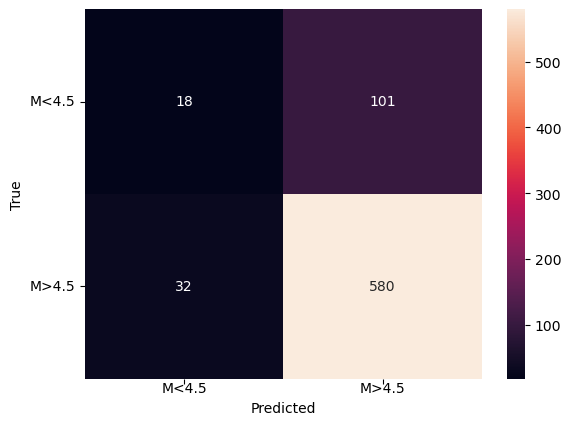

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
p = sns.heatmap(confusion_matrix(test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<4.5', 'M>4.5'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<4.5', 'M>4.5'], rotation=0, va="center")

### ROC curve

34/34 [==============================] - 1s 35ms/step


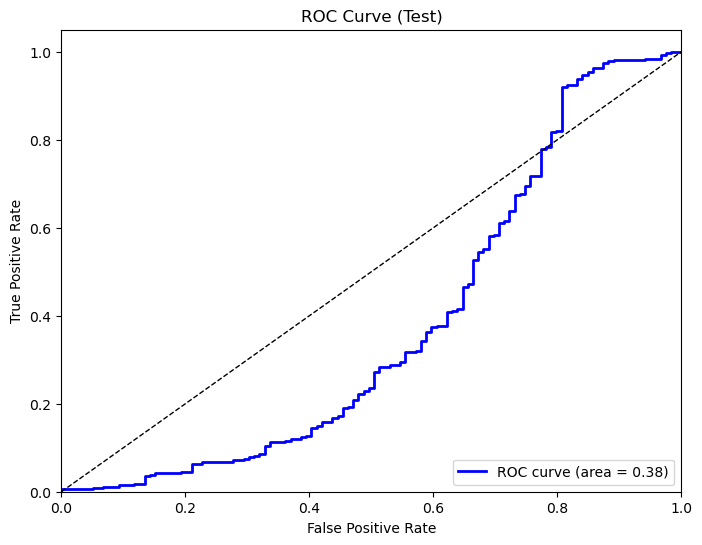

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_ROC_AUC(X,y):

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)
    # y_pred = scaler.inverse_transform(y_prob)
    # y_test = scaler.inverse_transform(y)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(test[:-n_input].flatten() >= mag, y_pred.flatten())
    roc_auc = auc(fpr, tpr)

    # Plot micro-average ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
            ''.format(roc_auc), color='blue', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    # plt.savefig(savefig)
    plt.show()

plot_ROC_AUC(test_generator, test)

# ConvLSTM2D

### Create 5D tensor

In [62]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
freq = 'W'
binsize = 5
longitude_W = 134 # minimum is 134
longitude_E = 174 # maximum is 174
latitude_S = 10 # minimum is 10
latitude_N = 60 # minimum is 60

# load earthquake data for defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E+1, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N+1, binsize))  # Change bin size to 2 degrees

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level="Time")]).max()['Magnitude']
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor_convLSTM with shape (1, time, depth, longitude, latitude)
time = len(grouped.columns)
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
tensor_convLSTM = np.zeros((1, time, longitude, latitude, 1))

for t in range(time):
    tensor_convLSTM[0, t, :, :, 0] = grouped.iloc[:, t].values.reshape(longitude, latitude)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor_convLSTM = np.transpose(tensor_convLSTM, axes=(0, 1, 4, 3, 2))
tensor_convLSTM = np.flip(tensor_convLSTM, axis=3)
# Print the shape of the resulting tensor_convLSTM
print(tensor_convLSTM.shape)


(1, 2609, 1, 10, 8)


### Plot timesteps of 5D tensor

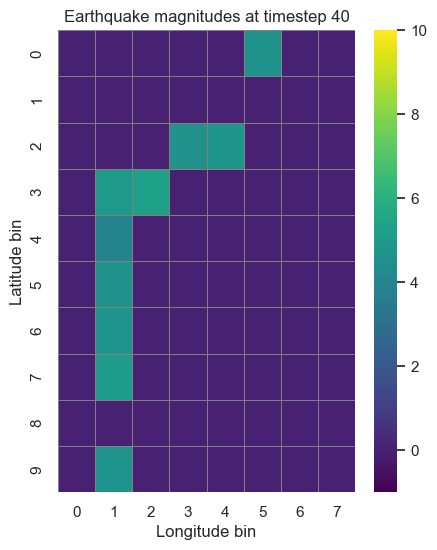

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a timestep to plot (e.g. the first timestep)
timestep = 40

# Extract the data for the chosen timestep from the tensor
# tensor_convLSTM = tf.cast(tf.reduce_max(tensor_convLSTM, axis=2, keepdims=True) > 0, dtype=tf.int32)

data = tensor_convLSTM[0, timestep, 0, :, :]

# Create a heatmap plot of the data using Seaborn
sns.set(rc={'figure.figsize':(4.8,6)})
sns.heatmap(data, cmap='viridis', vmin=-1, vmax=10, linewidths=0.5, linecolor='grey', annot=False)

# Set the plot title and axis labels
plt.title(f'Earthquake magnitudes at timestep {timestep}')
plt.xlabel('Longitude bin')
plt.ylabel('Latitude bin')

# Show the plot
plt.show()


### splitting the data

In [64]:
from sklearn.model_selection import train_test_split

# split data in train en test set
dataset_convLSTM = tensor_convLSTM.reshape((tensor_convLSTM.shape[1], tensor_convLSTM.shape[2], tensor_convLSTM.shape[3], tensor_convLSTM.shape[4]))

train, val_test = train_test_split(dataset_convLSTM, test_size=.4, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)


### Generate datasets from timeseries V1 (not shuffled)

In [65]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  dataset = timeseries_dataset_from_array(input_data, (targets >= cutoff).astype(int), sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

# Set lookback timewindow
timewindow = 10
cutoff = 4.5

train_dataset = dataset_generator(train, timewindow, cutoff)
val_dataset = dataset_generator(val, timewindow, cutoff)
test_dataset = dataset_generator(test, timewindow, cutoff)

# Create train set
for batch in train_dataset:
    X_train, y_train = batch

y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, y_train.shape[1], y_train.shape[2], y_train.shape[3]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_train = tf.cast(tf.reduce_max(y_train, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val, y_val = batch

y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, y_val.shape[1], y_val.shape[2], y_val.shape[3]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_val = tf.cast(tf.reduce_max(y_val, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test, y_test = batch

y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, y_test.shape[1], y_test.shape[2], y_test.shape[3]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_test = tf.cast(tf.reduce_max(y_test, axis=2, keepdims=True) > 0, dtype=tf.int32)

### Generate datasets from timeseries V2 (shuffled)

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  dataset = timeseries_dataset_from_array(input_data, (targets >= cutoff).astype(int), sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

timewindow = 10
cutoff = 4.5

batches = dataset_generator(dataset_convLSTM, timewindow, cutoff)
for batch in batches:
    X, y = batch
    
y = tf.reshape(y, shape=[y.shape[0], 1, y.shape[1], y.shape[2], y.shape[3]])
y = tf.cast(tf.reduce_max(y, axis=2, keepdims=True) > 0, dtype=tf.int32)

X_train, X_val_test = train_test_split(np.array(X), test_size=.4, shuffle=True, random_state=43)
X_val, X_test = train_test_split(X_val_test, test_size=.5, shuffle=True, random_state=43)

y_train, y_val_test = train_test_split(np.array(y), test_size=.4, shuffle=True, random_state=43)
y_val, y_test = train_test_split(y_val_test, test_size=.5, shuffle=True, random_state=43)

### Modelconstruction of convLSTM2D

In [66]:
from keras import layers, regularizers
import keras
keras.backend.clear_session()

from tensorflow.keras import layers, models

# Construct the inputut layer with no definite frame size.
input = layers.Input(shape=(X_train.shape[1:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.BatchNormalization()(input)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format = "channels_first",
    # kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
    data_format = "channels_first",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)

x = tf.reshape(x, (-1, 1, x.shape[1], x.shape[2], x.shape[3]))
x = layers.Conv3D(filters=x.shape[4], kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)
# Next, we will build the complete model and compile it.
model = keras.models.Model(input, x)
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1, 10, 8)]    0         
                                                                 
 batch_normalization (BatchN  (None, 10, 1, 10, 8)     32        
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 16, 10, 8)     9856      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 16, 10, 8)    32        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 10, 8)          72        
                                                                 
 batch_normalization_2 (Batc  (None, 1, 10, 8)         32    

### Modeltraining of convLSTM2D

In [67]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 32

# Fit the model to the training data.
model.fit(x=X_train,
          y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

Epoch 1/100
49/49 [==============================] - 6s 82ms/step - loss: 0.6594 - precision: 0.1364 - recall: 0.6643 - accuracy: 0.2174 - val_loss: 0.6636 - val_precision: 0.3399 - val_recall: 0.2373 - val_accuracy: 0.1330 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 4s 86ms/step - loss: 0.5606 - precision: 0.2627 - recall: 0.7046 - accuracy: 0.3223 - val_loss: 0.6321 - val_precision: 0.2414 - val_recall: 0.3488 - val_accuracy: 0.1217 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 5s 95ms/step - loss: 0.4371 - precision: 0.3797 - recall: 0.5050 - accuracy: 0.3228 - val_loss: 0.6382 - val_precision: 0.1632 - val_recall: 0.4396 - val_accuracy: 0.1396 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 5s 96ms/step - loss: 0.3291 - precision: 0.4809 - recall: 0.2681 - accuracy: 0.3215 - val_loss: 0.6079 - val_precision: 0.2262 - val_recall: 0.5214 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 5/100
49/49 [==============================] -

### Predict

In [68]:
y_pred = model.predict(X_test)

16/16 [==============================] - 0s 16ms/step


### Plot timesteps of 5D tensor

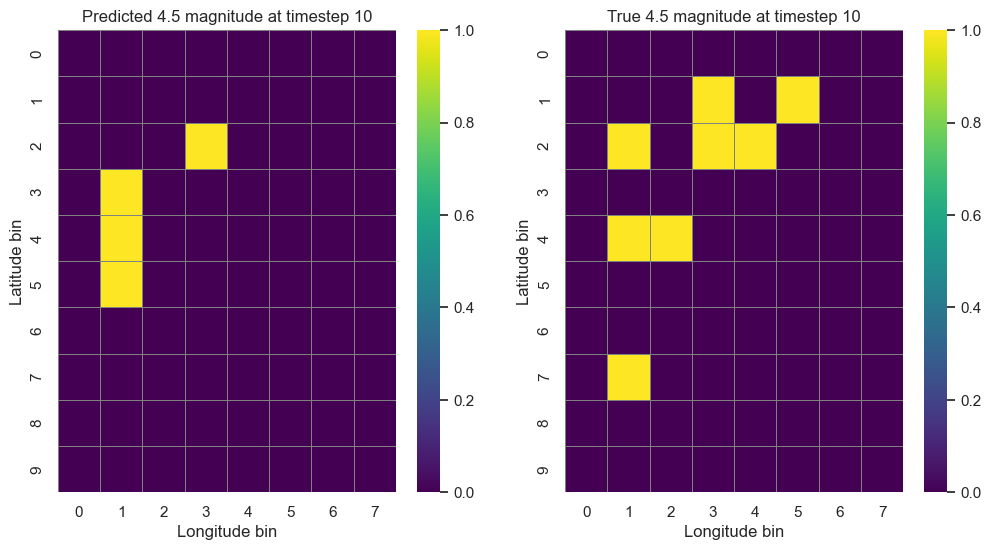

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt


# Choose timesteps to plot
timestep = 10

# Extract the data for the chosen timesteps from the tensor
data1 = y_pred[timestep, 0, 0, :, :] > .5
data2 = y_test[timestep, 0, 0, :, :]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the data in each subplot
sns.heatmap(data1, cmap='viridis', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax1)
sns.heatmap(data2, cmap='viridis', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax2)

# Set the plot titles and axis labels
ax1.set_title(f'Predicted {cutoff} magnitude at timestep {timestep}')
ax1.set_xlabel('Longitude bin')
ax1.set_ylabel('Latitude bin')

ax2.set_title(f'True {cutoff} magnitude at timestep {timestep}')
ax2.set_xlabel('Longitude bin')
ax2.set_ylabel('Latitude bin')

# Show the plot
plt.show()

### Confusion matrix

[Text(0, 0.5, 'M<4.5'), Text(0, 1.5, 'M>=4.5')]

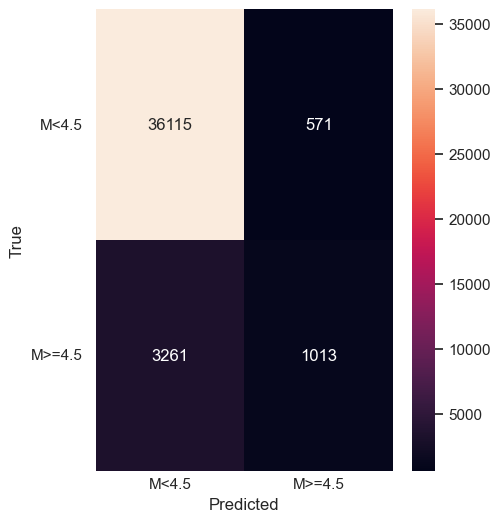

In [80]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
p = sns.heatmap(confusion_matrix(np.array(y_test).flatten(), y_pred.flatten() >= 0.5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<4.5', 'M>=4.5'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<4.5', 'M>=4.5'], rotation=0, va="center")

### Evaluation metrics

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('F1 score: %f' % f1)

class_names = ['M<6', 'M>=6']

print(classification_report(np.array(y_test).flatten(), y_pred.flatten() >= 0.5, target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(y_test, axis=0)

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("zeroR:", round(zeroR,4))

Accuracy: 0.906445
Precision: 0.639520
Recall: 0.237015
F1 score: 0.345852
              precision    recall  f1-score   support

         M<6       0.92      0.98      0.95     36686
        M>=6       0.64      0.24      0.35      4274

    accuracy                           0.91     40960
   macro avg       0.78      0.61      0.65     40960
weighted avg       0.89      0.91      0.89     40960

zeroR: 0.9198


### ROC curve

16/16 [==============================] - 0s 24ms/step


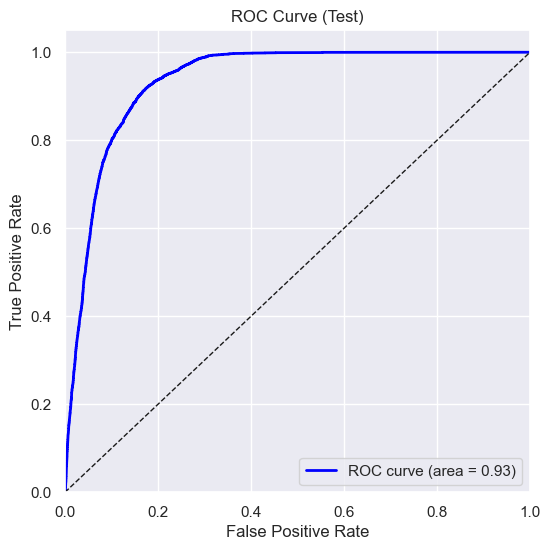

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_ROC_AUC(X,y):

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)
    # y_pred = scaler.inverse_transform(y_prob)
    # y_test = scaler.inverse_transform(y)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(np.array(y_test).flatten(), np.array(y_pred).flatten())
    roc_auc = auc(fpr, tpr)

    # Plot micro-average ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
            ''.format(roc_auc), color='blue', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    # plt.savefig(savefig)
    plt.show()

plot_ROC_AUC(X_test, y_test)

# ConvLSTM3d

### Create 6D tensor

In [83]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
# Can be treated as 2D when depthsize is set to 700
freq = 'W'
binsize = 5
longitude_W = 134 # minimum is 134
longitude_E = 174 # maximum is 174
latitude_S = 10 # minimum is 10
latitude_N = 60 # minimum is 60
depthsize = 175

# load earthquake data for a specific area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E+1, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N+1, binsize))  # Change bin size to 2 degrees
df['Depth_bin'] = pd.cut(df['Depth'], bins=np.arange(0, 700+depthsize, depthsize))

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', 'Depth_bin', pd.Grouper(freq=freq, level="Time")]).max()['Magnitude']
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor6D_convLSTM3D with shape (1, time, depth, longitude, latitude)
time = len(grouped.columns)
depth = len(grouped.index.levels[2])
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
channels = 1
tensor6D_convLSTM3D = np.zeros((1, time, channels, longitude, latitude, depth))

for t in range(time):
    tensor6D_convLSTM3D[0, t, 0, :, :, :] = grouped.iloc[:, t].values.reshape(longitude, latitude, depth)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor6D_convLSTM3D = np.transpose(tensor6D_convLSTM3D, axes=(0, 1, 2, 4, 3, 5))
tensor6D_convLSTM3D = np.flip(tensor6D_convLSTM3D, axis=3)
# Print the shape of the resulting tensor6D_convLSTM3D
print(tensor6D_convLSTM3D.shape)
print("mean:", tensor6D_convLSTM3D.flatten()[tensor6D_convLSTM3D.flatten() > 0].mean())

(1, 2609, 1, 10, 8, 4)
mean: 4.6189869848867335


### Plot timesteps of 6D tensor

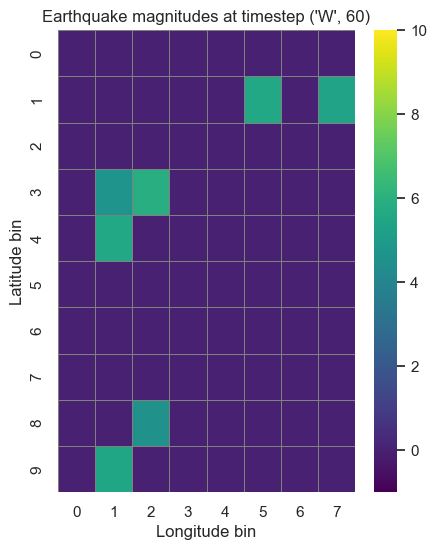

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a timestep to plot (e.g. the first timestep)
timestep = 60
depth = 0
channel = 0

# Extract the data for the chosen timestep from the tensor
# tensor_convLSTM = tf.cast(tf.reduce_max(tensor_convLSTM, axis=2, keepdims=True) > 0, dtype=tf.int32)

data = tensor6D_convLSTM3D[0, timestep, channel, :, :, depth]

# Create a heatmap plot of the data using Seaborn
sns.set(rc={'figure.figsize':(4.8,6)})
sns.heatmap(data, cmap='viridis', vmin=-1, vmax=10, linewidths=0.5, linecolor='grey', annot=False)

# Set the plot title and axis labels
plt.title(f'Earthquake magnitudes at timestep {freq, timestep}')
plt.xlabel('Longitude bin')
plt.ylabel('Latitude bin')

# Show the plot
plt.show()

### Splitting the data

In [85]:
from sklearn.model_selection import train_test_split

# split data in train en test set
tensor6D_convLSTM3D = tensor6D_convLSTM3D.reshape((tensor6D_convLSTM3D.shape[1], tensor6D_convLSTM3D.shape[2], tensor6D_convLSTM3D.shape[3], tensor6D_convLSTM3D.shape[4], tensor6D_convLSTM3D.shape[5]))

train, val_test = train_test_split(tensor6D_convLSTM3D, test_size=.4, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

### Generate dataset from timeseries V1 (not shuffled)

In [87]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  targets = (targets >= cutoff).astype(int)
  dataset = timeseries_dataset_from_array(input_data, targets, sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

# Set lookback timewindow
timewindow = 52
cutoff = 4.5

train_dataset = dataset_generator(train, timewindow, cutoff)
val_dataset = dataset_generator(val, timewindow, cutoff)
test_dataset = dataset_generator(test, timewindow, cutoff)

# Create train set
for batch in train_dataset:
    X_train, y_train = batch

y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, 1, y_train.shape[2], y_train.shape[3], y_train.shape[4]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_train = tf.cast(tf.reduce_max(y_train, axis=5, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val, y_val = batch

y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, 1, y_val.shape[2], y_val.shape[3], y_val.shape[4]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_val = tf.cast(tf.reduce_max(y_val, axis=5, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test, y_test = batch

y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, 1, y_test.shape[2], y_test.shape[3], y_test.shape[4]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_test = tf.cast(tf.reduce_max(y_test, axis=5, keepdims=True) > 0, dtype=tf.int32)

### Modelconstruction of ConvLSTM3D

In [88]:
from keras import layers, regularizers
import keras
keras.backend.clear_session()

from tensorflow.keras import layers, models

# Construct the inputut layer with no definite frame size.
input = layers.Input(shape=(X_train.shape[1:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.BatchNormalization()(input)
x = layers.ConvLSTM3D(
    filters=12,
    kernel_size=(3, 3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format = "channels_first",
    # kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM3D(
    filters=1,
    kernel_size=(3, 3, 3),
    padding="same",
    return_sequences=False,
    # return_state=True,
    activation="relu",
    data_format = "channels_first",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) #l1 reduces weights to zero, l2 reduces towards zero
)(x)
x = layers.BatchNormalization()(x)
# x = x[0]
x = tf.reshape(x, (-1, 1, 1, x.shape[2], x.shape[3], x.shape[4]))
x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="linear", padding="same")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(input, x)
print(model.summary())

model.compile(loss='MSE', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52, 1, 10, 8, 4)  0         
                             ]                                   
                                                                 
 batch_normalization (BatchN  (None, 52, 1, 10, 8, 4)  16        
 ormalization)                                                   
                                                                 
 conv_lstm3d (ConvLSTM3D)    (None, 52, 12, 10, 8, 4)  16896     
                                                                 
 batch_normalization_1 (Batc  (None, 52, 12, 10, 8, 4)  16       
 hNormalization)                                                 
                                                                 
 conv_lstm3d_1 (ConvLSTM3D)  (None, 1, 10, 8, 4)       1408      
                                                             

### Modeltraining of ConvLSTM3D

In [89]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 32

# Fit the model to the training data.
model.fit(x=X_train,
          y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

Epoch 1/500
43/48 [=========================>....] - ETA: 6s - loss: 0.3838 - precision: 0.1957 - recall: 0.1442 - accuracy: 0.8867

### Predict

In [ ]:
y_pred = model.predict(X_test)

### Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
p = sns.heatmap(confusion_matrix(np.array(y_test).flatten(), y_pred.flatten() >= 0.5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<4.5', 'M>=4.5'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<4.5', 'M>=4.5'], rotation=0, va="center")

### Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('F1 score: %f' % f1)

class_names = ['M<6', 'M>=6']

print(classification_report(np.array(y_test).flatten(), y_pred.flatten() >= 0.5, target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(y_test, axis=0)[0, 0, :, :, 0]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("ZeroR:", round(zeroR,4))

### ROC curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_ROC_AUC(X,y):

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)
    # y_pred = scaler.inverse_transform(y_prob)
    # y_test = scaler.inverse_transform(y)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(np.array(y_test).flatten(), np.array(y_pred).flatten())
    roc_auc = auc(fpr, tpr)

    # Plot micro-average ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
            ''.format(roc_auc), color='blue', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    # plt.savefig(savefig)
    plt.show()

plot_ROC_AUC(X_test, y_test)